In [15]:
# Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import clone
%matplotlib inline

# Data Preprocessing and Feature Engineering
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as sw
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import ItalianStemmer
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import TruncatedSVD

#Model Selection and Validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, f1_score


def labels_to_ints(labels):
    return np.array(list(map(lambda x : 1 if x == "pos" else 0, labels)))

def ints_to_labels(labels):
    return list(map(lambda x : "pos" if x == 1 else "neg", labels))

In [16]:
dev_df = pd.read_csv("datasets/development.csv")
X_dev = dev_df.loc[:, 'text']
y_dev = labels_to_ints(dev_df.loc[:, 'class'])

ev_df = pd.read_csv("datasets/evaluation.csv")
X_ev = ev_df.loc[:, 'text']

X_dev.shape[0] + X_ev.shape[0]

41077

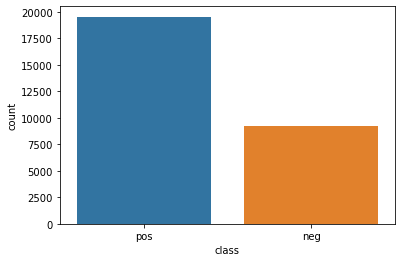

In [17]:
sns.countplot(x= 'class',data = dev_df)


In [18]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'url', text) # remove URLs
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "email", text) # remove email
    text = re.sub(r'@([^\s]+)', r'\1', text) # remove eventually @<word>
    text = re.sub(r'#([^\s]+)', r'\1', text) # remove eventually hashtag 
    text = re.sub(r'[#@]', " ", text) # remove eventually isolated @#
    text = re.sub("'", "' ", text)  #insert a space in every word with the <'> in order to be catched by tokenizer and filtered
    text = re.sub(r"([.]*)([0-9]+)([.]*)", r"\0 \1", text) # i.e ciao123come20va -> ciao come va
    text = re.sub("([*.\-/+°])", " ", text) # remove special characters from words of kind "..<word>" "***" "-<word>" "..<word>"
    return text

class LemmaTokenizer(object):
    def __init__(self):
        self.stemmer = ItalianStemmer()
    
    def __call__(self, text):
        lemmas = []
        regex = re.compile("[0-9]+")
        stopwords = sw.words('italian') + ['quantum', "url", "email", 'sempre', 'stato', 'stati', 'stata', 'state', 'ogni', 'tutto', 'tutti', 'tutta', 'tutte']
        text = preprocess_text(text)
        for t in word_tokenize(text):
            t = t.strip()
            if t not in string.punctuation and 3 < len(t) < 16 and not regex.match(t) and t not in stopwords:
                lemma = self.stemmer.stem(t)
                lemmas.append(lemma)
        return lemmas
    

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, shuffle=True, test_size=0.25)
params_vect = {'min_df': [3, 5, 8, 10],
               'binary': [True, False]}
vectorizers = [CountVectorizer(input='content', tokenizer=LemmaTokenizer(), ngram_range=(1,2), **config)
               for config in ParameterGrid(params_vect)]

params_model = {'C': [1, 5, 10]}
models = [LogisticRegression(max_iter=180, n_jobs=8, **config) for config in ParameterGrid(params_model)]

pipelines = [Pipeline([
    ('count', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('classifier', model),
]) for vectorizer in vectorizers for model in models]


In [20]:
labels_predicted = []
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    labels_predicted.append(y_pred)
    

In [21]:
# Redo of the parameter combinations just to extract the best one considered the best_index below
total_config = []
for conf_vec in ParameterGrid(params_vect):
    for conf_mod in ParameterGrid(params_model):
        total = conf_vec
        total.update(conf_mod)
        total_config.append(total)

In [22]:
f1_scores = [f1_score(y_test, y_pred) for y_pred in labels_predicted]
best_ind = np.argmax(f1_scores)
best_pipeline = pipelines[best_ind]
print(classification_report(y_test, labels_predicted[best_ind]))
print(f"Total f1 score: {np.max(f1_scores)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, labels_predicted[best_ind])}")
print(f"CountVectorizer best params: {list(total_config[best_ind].items())[:2]}")
print(f"Logistic Regression best params: {list(total_config[best_ind].items())[2:]}")

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2265
           1       0.97      0.98      0.98      4924

    accuracy                           0.97      7189
   macro avg       0.96      0.96      0.96      7189
weighted avg       0.97      0.97      0.97      7189

Total f1 score: 0.9759401536595228
Confusion Matrix:
[[2124  141]
 [  97 4827]]
CountVectorizer best params: [('binary', False), ('min_df', 10)]
Logistic Regression best params: [('C', 10)]


In [23]:
# Tuning for the components selection
final_pipe = clone(pipelines[best_ind])
final_pipe.steps.insert(2, ('svd', TruncatedSVD(n_components=10000)))
final_pipe.fit(X_dev, y_dev)

Pipeline(memory=None,
         steps=[('count',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.LemmaTo...
                 TruncatedSVD(algorithm='randomized', n_components=10000,
                              n_iter=5, random_state=None, tol=0.0)),
                ('classifier',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
            

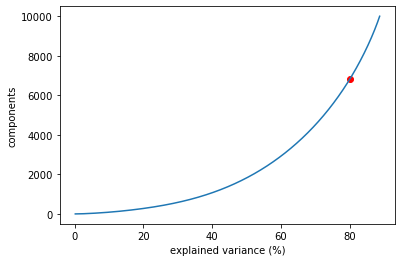

Total components: 26699
Kept components: 6820


In [30]:
cum_variance = np.cumsum(final_pipe['svd'].explained_variance_ratio_)
n_comps = np.argmax(cum_variance > .8)
_, ax = plt.subplots()
ax.plot(cum_variance*100, list(range(len(cum_variance))))
ax.set_xlabel('explained variance (%)')
ax.set_ylabel('components')
ax.scatter(cum_variance[n_comps]*100, n_comps, marker='o', c='red')
plt.show()
print(f"Total components: {len(best_pipeline['count'].get_feature_names())}")
print(f"Kept components: {n_comps}")


In [25]:
# Training of the final model
pipeline_ev = Pipeline([
    ('count', best_pipeline['count']),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=n_comps)),
    ('classifier', best_pipeline['classifier']),
])
pipeline_ev.fit(X_dev, y_dev)
y_pred_ev = pipeline_ev.predict(X_ev)

In [33]:
# Write file
with open("datasets/sample_submission8.csv", "w", encoding="utf8") as sub:
    sub.write("Id,Predicted\n")
    for i, label in enumerate(ints_to_labels(y_pred_ev)):
        sub.write(f"{i},{label}\n")
 



In [32]:
#TOP 25 features
coefs = pipeline_ev['tfidf'].idf_
feature_names = pipeline_ev['count'].get_feature_names()
best_features = [feature_names[i] for i in np.argsort(coefs)[::-1]]
for i,feature in enumerate(best_features[:25]):
    print(f"{i+1}. {feature}")

1. estrem puliz
2. confort puliz
3. condizion dispon
4. condizion general
5. condizion lett
6. condizion posizion
7. struttur null
8. condizion serviz
9. quel tocc
10. conferm hotel
11. struttur lasc
12. confort camer
13. molt allegr
14. quind andar
15. quind cos
16. moj
17. confortevol cald
18. struttur dop
19. confortevol compless
20. quind attenzion
21. quind aver
22. confortevol dorm
23. quind ben
24. mogl camer
25. struttur confortevol
